In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False

from keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM

Using TensorFlow backend.
/home/james/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/james/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/james/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/james/.local/lib/python3.6/site-packages/tensorflow/python/fra

## Utility functions used in the notebook

In [2]:
def rbm_gibbs_sample_image(rbm, im, steps):
  assert len(im.shape) < 3
  if len(im.shape) == 2:
    rows = im.shape[0]
    cols = im.shape[1]
    im = im.reshape((-1))
  else:
    im = im.copy()
  for _ in range(steps):
    im = rbm.gibbs(im)
  if rows is not None and cols is not None:
    im = im.reshape((rows, cols))
  return im.astype('float32')
    
def image_palette(X, nr = 0, m = 20):
  if nr is 0:
    nr = X.shape[0]
  return np.rollaxis(np.rollaxis(X[0:nr].reshape(m, -1, 28, 28), 0, 2), 1, 3).reshape(-1, m * 28)

def remove_rows(X, start, end):
  X = X.copy()
  if len(X.shape) == 2:
    X[start:end] = 0
  elif len(X.shape) == 3:
    X[:,start:end] = 0
  return X

## Load and show the mnist data

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0],-1))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_test = X_test[0:100]

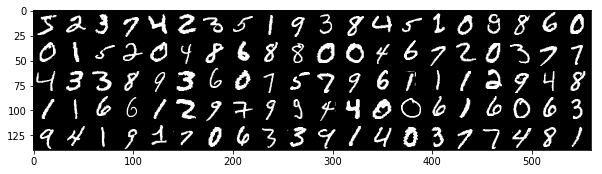

In [4]:
flattened_images = image_palette(X_train, 100)
plt.figure(figsize=(10,20))
plt.imshow(flattened_images)

## Train the RBM
**Exercise** What is the effect of the different parameters: **n_components** and **n_iter**. These parameters are, respectively, the number of components, and the number of iterations. <br/>
Evaluate the performance visually in the next code cell.


In [63]:
rbm = BernoulliRBM(n_components=25, learning_rate=0.01, random_state=0, n_iter=30, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -193.15, time = 2.75s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -171.81, time = 3.17s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -162.99, time = 3.16s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -154.72, time = 3.13s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -148.53, time = 3.13s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -145.68, time = 3.13s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -140.21, time = 3.13s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -137.31, time = 3.12s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -135.43, time = 3.13s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -132.77, time = 3.14s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -129.80, time = 3.13s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -127.82, time = 3.15s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -125.35, time = 3.16s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -124.21, time = 3.13s
[BernoulliRBM] 

BernoulliRBM(learning_rate=0.01, n_components=25, n_iter=30, random_state=0,
             verbose=True)

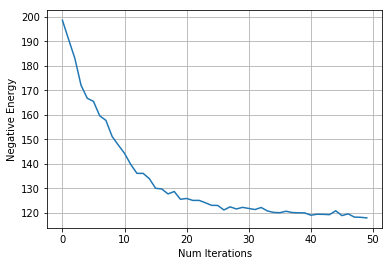

In [64]:
likelihoods = [198.55, 190.71, 183.02, 172.03, 166.73, 165.47, 159.59, 157.73, 151.19, 147.66, 144.28, 139.75, 136.12, 136.12, 133.94, 130.04, 129.75, 127.75, 128.72, 125.55, 125.89, 125.09, 125.11, 124.16, 123.10, 123.04, 121.21, 122.47, 121.61, 122.26, 121.82, 121.38, 122.21, 120.80, 120.20, 120.09, 120.68, 120.15, 120.05, 120.01, 119.07, 119.46, 119.41, 119.29, 120.87, 118.90, 119.62, 118.29, 118.22, 117.96]
fig, ax = plt.subplots()
ax.plot(likelihoods)

ax.set(xlabel='Num Iterations', ylabel='Negative Energy')
ax.grid()

fig.savefig("iterations.pdf")
plt.show()

## Sample the trained RBM and show the result
The gibbs_steps variable determines how many Gibbs sampling steps will be performed for each test image i.e. with the test images as initialization. <br/>
**Exercise** Try different values and observe the result. Can you explain the result? <br/>
Compare the result with the original test images, shown one cell lower.


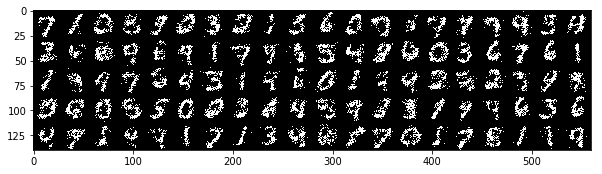

In [66]:
gibbs_steps = 10
a = X_test.copy()
for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    a[i] = rbm.gibbs(a[i])

image = image_palette(a)

fig = plt.figure(figsize=(10,20))
plt.imshow(image)
plt.imsave('gibbs10000.png', image)

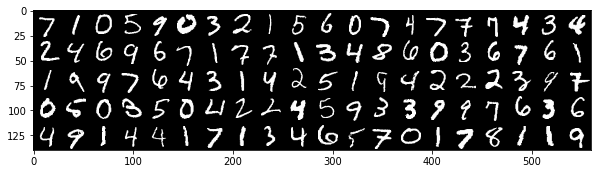

In [67]:
fig = plt.figure(figsize=(10,20))
image = image_palette(X_test)
plt.imshow(image)
plt.imsave("gibbstest.png", image)


## Reconstruction of unseen images
In this cell, we will remove pixel rows from certain images. Using the recently trained RBM, we will then try to reconstruct the original images.  <br/>
The following variables control this process: <br/>


*   **reconstruction_gibbs_steps**: The number of gibbs steps used to reconstruct the image.
*   **start_test_index**: The first index of the test set to use.
*   **nr**: the number of images starting from **start_test_index** to reconstruct.
*   **start_row_to_remove**:  The index of the first row that should be removed.
*   **end_row_to_remove**: The index up to which the rows should be removed.

**Exercise** Adjust these variables and observe the result of the reconstruction in the shown image.
What is the role of the previously seen RBM hyperparameters on the reconstruction? <br/>
How many rows can you remove such that reconstruction is still possible? <br/>
In the next code cell, the removed rows will be replaced by the reconstructed rows.




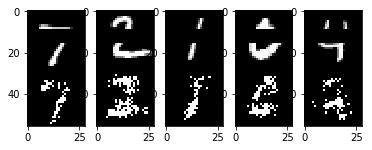

In [68]:
reconstruction_gibbs_steps = 1
start_test_index = 0
nr = 5
start_row_to_remove = 9
end_row_to_remove = 16
to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
to_reconstruct = remove_rows(to_reconstruct, start_row_to_remove, end_row_to_remove)
reconstructed = np.zeros(to_reconstruct.shape)
for i in range(nr):
  reconstructed[i] = rbm_gibbs_sample_image(rbm, to_reconstruct[i], reconstruction_gibbs_steps)
combined_images = np.concatenate((to_reconstruct,reconstructed), axis=1)
fig = plt.figure()
for i in range(nr): 
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(combined_images[i])

plt.show()
plt.savefig('reconstruction.png')

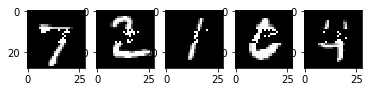

In [69]:
start_row_to_remove
end_row_to_remove
to_reconstruct[:,start_row_to_remove:end_row_to_remove] = reconstructed[:,start_row_to_remove:end_row_to_remove]
fig = plt.figure()
for i in range(nr): 
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(to_reconstruct[i])

plt.show()

## Component visualisation
In the final cell, the components (weights of each neuron) of the RBM are shown.<br/> 
Observing these components (think back to CNNs) may offer insights into the trained model.

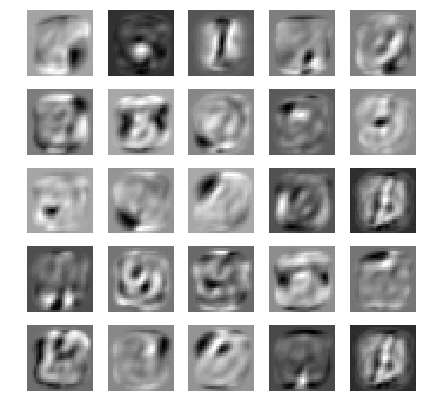

In [73]:
plt.figure(figsize=(7, 7))
nr_components = rbm.components_.shape[0]
for i in range(nr_components):
    c = rbm.components_[i]
    plt.subplot(5, np.ceil(nr_components/5), i + 1)
    plt.imshow(c.reshape((28, 28)), cmap = "gray", interpolation='nearest')
    plt.axis('off')